# Reproducing Optimus 5 Prime Model (CNN - from the Seelig Lab) - Varying Length

In this notebook, we will implement the Optimus 5 Prime Model on the VARYING length data, evaluate and analyze the output to be able to compare the performance of other models compared to Optimus 5 Prime. 

In [2]:
import pandas as pd
import numpy as np
import keras
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import  Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dropout
from keras.layers.core import Dense
import seaborn as sns
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
import scipy.stats as stats

from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

## 1. We read the preprocessed data. 

In [3]:
#We load the data
data_path = "Data/GSM4084997_varying_length_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')

## 2. We split the data in training, validation and testing set.

### For dividing our dataset into training and validation set, we will follow the procesure seen in the paper which consists in taking the top 100 UTRs with most sequencing reads at each length from 25 to 100nt as the test set.

In [4]:
df["one-hot encoding"] = df["one-hot encoding"].apply(ast.literal_eval)
df["one-hot encoding"]

0         [[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...
1         [[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...
2         [[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...
3         [[0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0,...
4         [[0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1,...
                                ...                        
101721    [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
101722    [[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...
101723    [[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...
101724    [[1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
101725    [[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
Name: one-hot encoding, Length: 101726, dtype: object

In [5]:
#We follow the same procedure as in the paper (this cell follows similar code than in the paper)
df_test = pd.DataFrame(columns=df.columns)
for i in range(25,101):
    if (i in df["len"].values):
        df_len = df[df['len']== i]
        df_len = df_len.sort_values('total_reads', ascending=False)
        df_len.reset_index(inplace=True, drop=True)
        df_test = df_test.append(df_len.iloc[:100])

In [6]:
#We use the other rows as training set
df_test_indices = df_test.index
df_train_indices = set(df.index) ^ set(df_test_indices)
print(len(df_train_indices))
print(len(df_test_indices))
print(len(df))

101626
7600
101726


In [7]:
df_train = df.loc[df_train_indices]
df_train.head()

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r8,r9,r10,r11,r12,total,rl,len,one-hot encoding,scaled_rl
100,84339,CCCAAACAATGACCATCTGACTCCGGTCAAGTT,random,251,306,327,299,313,199,81,...,0.039507,0.043015,0.047276,0.051164,0.132952,0.001017,4.146183,33,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1,...",-0.858599
101,9045,CCATATTTGAGTAAGCCACTCACATT,random,154,154,113,97,267,323,211,...,0.083512,0.083486,0.074304,0.078345,0.058800,0.000933,5.788789,26,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.371124
102,75027,CATACCATATGCAAAGTCTATCTTG,random,188,162,198,204,345,309,142,...,0.056654,0.060465,0.068254,0.076314,0.092855,0.000970,5.137631,25,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1,...",-0.116360
103,92334,GCAAACCAAACTCACTACCCCTGACACC,human,172,107,86,76,172,260,185,...,0.112399,0.098983,0.092389,0.089096,0.047820,0.000895,6.232782,28,"[[0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1,...",0.703515
104,62996,GGAATGGCCTGCTTCGACTGTTCTT,random,437,876,528,272,125,76,37,...,0.023734,0.028215,0.038460,0.030416,0.053246,0.001079,2.816402,25,"[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1,...",-1.854128


In [8]:
X_train = df_train["one-hot encoding"]
X_train.shape

(101626,)

In [9]:
X_train = np.array([np.array(x) for x in X_train])
X_train.shape

(101626, 100, 4)

In [10]:
#Sanity check 
print("X_train shape: {}".format(X_train.shape))

X_train shape: (101626, 100, 4)


In [11]:
y_train = df_train["rl"]

## 3. We build our model and train it using our datasets.

In [20]:
def train_model(x, y, border_mode='same', inp_len=100, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [12]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [22]:
model = train_model(X_train, y_train, nb_epoch=7)

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/7
794/794 [==============================] - 97s 120ms/step - loss: 1.4739
Epoch 2/7
794/794 [==============================] - 94s 118ms/step - loss: 0.8273
Epoch 3/7
794/794 [==============================] - 94s 118ms/step - loss: 0.7672
Epoch 4/7
794/794 [==============================] - 94s 119ms/step - loss: 0.7387
Epoch 5/7
794/794 [==============================] - 98s 123ms/step - loss: 0.7021
Epoch 6/7
794/794 [==============================] - 94s 118ms/step - loss: 0.6699
Epoch 7/7
794/794 [==============================] - 92s 116ms/step - loss: 0.6183


In [14]:
X_test = df_test["one-hot encoding"]

In [15]:
X_test = np.array([np.array(x) for x in X_test])

In [16]:
preds = model.predict(X_test).reshape(-1)
preds

array([4.614651 , 5.723056 , 5.6534305, ..., 6.445593 , 4.080193 ,
       6.07573  ], dtype=float32)

In [17]:
df_test["pred rl"] = preds.tolist()
df_test["pred rl"]

0     4.614651
1     5.723056
2     5.653430
3     4.556245
4     5.388730
        ...   
95    7.309050
96    4.895113
97    6.445593
98    4.080193
99    6.075730
Name: pred rl, Length: 7600, dtype: float64

In [18]:
r = r2(df_test["rl"], df_test["pred rl"])
print('r-squared = ', r)

r-squared =  0.7723944347990365


In [19]:
from sklearn.metrics import r2_score
r2_score(df_test["rl"], df_test["pred rl"])

0.7349253583239519

In [29]:
model.save('./saved_models/optimus_5_varying_length.hdf5')

## 4. We analyze the output

In [13]:
model = keras.models.load_model('./saved_models/optimus_5_varying_length.hdf5')

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


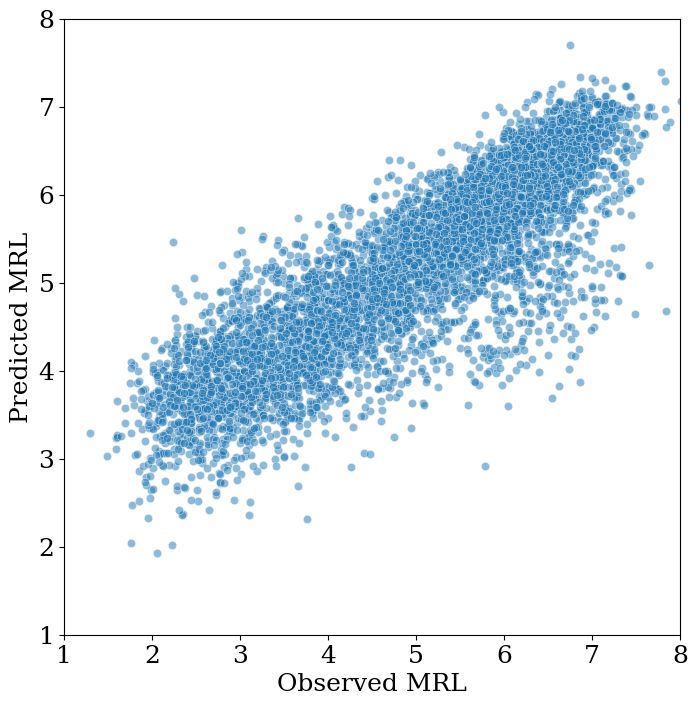

In [24]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test['rl'], df_test["pred rl"],linewidth = 0.5, alpha=0.5)
plt.xlabel('Observed MRL')
plt.ylabel('Predicted MRL') 
plt.xlim(1, 8)
plt.ylim(1, 8)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("Optimus_5_prime_varying.pdf", bbox_inches = "tight")
plt.show()

In [22]:
df_test_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' in x)]
df_test_no_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' not in x)]

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

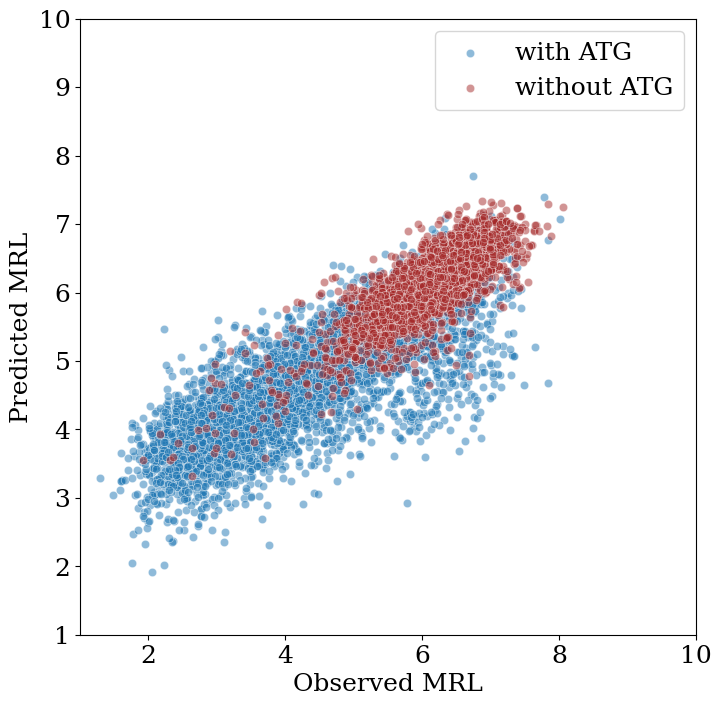

In [23]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test_atg["rl"], df_test_atg["pred rl"],linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(df_test_no_atg["rl"], df_test_no_atg["pred rl"],
                 linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'brown', legend = 'auto')
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.show()

## Analysis of the output

In [33]:
df_test["rl class"] = df_test["rl"].apply(round)
df_test["pred rl class"] = df_test["pred rl"].apply(round)
df_test["pred rl class"]
df_test["rl class"]

0     4
1     6
2     6
3     4
4     5
     ..
95    7
96    5
97    7
98    6
99    6
Name: rl class, Length: 7600, dtype: int64

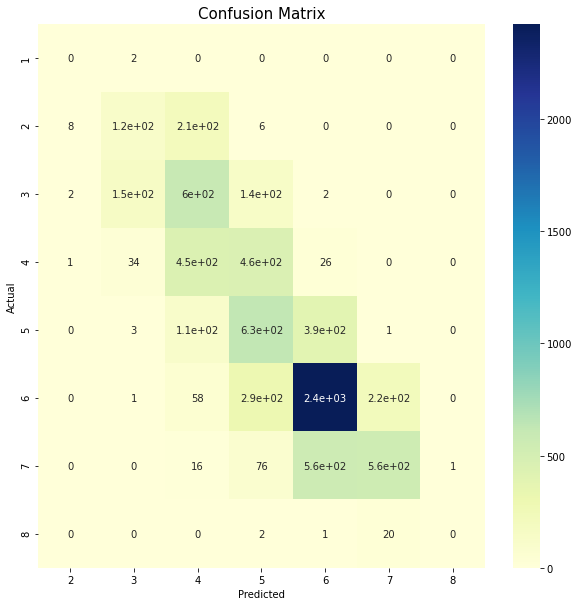

In [34]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(df_test["rl class"], df_test["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

In [35]:
mispredictions_df = df_test[df_test["rl class"] != df_test["pred rl class"]]
mispredictions_df.head()

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r11,r12,total,rl,len,one-hot encoding,scaled_rl,pred rl,rl class,pred rl class
0,30,CCTTCAATGATTACCTCTATCCCCA,random,291,448,539,529,527,338,170,...,0.059276,0.113321,0.001592,4.300281,25,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...",-0.743234,4.614651,4,5
3,57024,TCTCCCCCATGCCTTCGCATCCACC,random,445,655,668,463,293,213,79,...,0.037853,0.093758,0.001429,3.515382,25,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0,...",-1.330842,4.556245,4,5
7,35995,ACGCTCCCGGATTCTTCTCCTTCCG,random,237,179,212,178,368,393,223,...,0.078903,0.083875,0.001213,5.466858,25,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0,...",0.130113,5.855364,5,6
10,9027,TCCGGCACTCTCAGCCTTTCGTCCC,random,202,171,243,290,451,363,161,...,0.067636,0.123612,0.001217,5.091441,25,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",-0.150939,5.542498,5,6
11,63023,CCACTCCTGCCTTCGCACTCCCACC,random,266,198,236,189,335,403,260,...,0.067435,0.064575,0.001190,5.271071,25,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-0.016461,5.514914,5,6


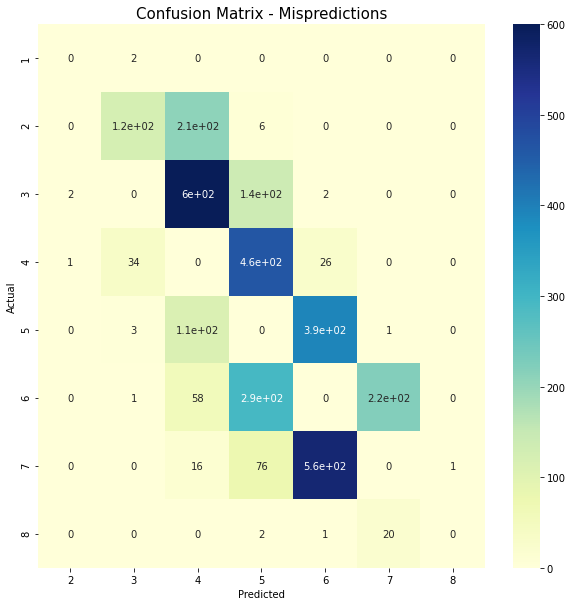

In [36]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(mispredictions_df["rl class"], mispredictions_df["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix - Mispredictions", fontsize = 15)
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_test = df_test["rl class"]
y_pred = df_test["pred rl class"]

print("Precision Score : ",precision_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.5560526315789474
Recall Score :  0.5560526315789474
